In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [92]:
data = pd.read_csv('car-data/car_price_prediction.csv')

data.head(10)

'''
Data Cleaning:
Levy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column
Mileage - Remove km and make it numerical 
Engine Volume - Is not numeric and contains strings 'Turbo'
Doors has following values and must be changed to 2, 4, or 6 (ordinal scale)

04-May    18332
02-Mar      777
>5          128
'''

"\nData Cleaning:\nLevy - Many values use '-' which should be replaced with the mean or median value of the numerical values of the column\nMileage - Remove km and make it numerical \nEngine Volume - Is not numeric and contains strings 'Turbo'\nDoors has following values and must be changed to 2, 4, or 6 (ordinal scale)\n\n04-May    18332\n02-Mar      777\n>5          128\n"

In [93]:
data['Manufacturer'].value_counts()

Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

In [94]:
def preprocess(data: pd.DataFrame):
   # Levy has many missing values
   data['Levy'] = pd.to_numeric(data['Levy'], errors='coerce')
   levy_mean_val = data['Levy'].mean()
   data['Levy'].fillna(levy_mean_val, inplace=True)
   
   # Mileage
   data['Mileage'] = pd.to_numeric((data['Mileage']).astype(str).str.replace(' km', '', regex=True), errors='coerce')

   # Doors
   data['Doors'] = data['Doors'].astype(str).str.extract(r'(\d+)', expand=False).astype(int).map({4: 4, 2: 2, 5: 6})  # Map values

   # Engine Volume
   data['Engine volume'] = pd.to_numeric(data['Engine volume'].astype(str).str.replace(' Trubo', '', regex=True), errors='coerce')

   # Find age of car rather than having year of production
   data['Age'] = 2025 - data['Prod. year']
   data = data.drop(columns=['Prod. year'])

   # Adjust column names and remove spaces
   data.columns = data.columns.str.strip().str.replace(' ', '_')

   # Drop ID column 
   data = data.drop(columns=['ID'])

   return data

def split_data(data: pd.DataFrame):
   # Split data 
   train, test = train_test_split(data, test_size=0.2, random_state=123)
   y_train = train.pop('Price') # Keep only price column in train 
   X_train = train
   y_test = test.pop('Price')
   X_test = test

   return X_train, y_train, X_test, y_test

def OHE_data(data: pd.DataFrame):
   # OHE Categorical Data
   # Removed Model (This adds over 1500 more columns)
   data = data.drop(columns=['Model'])
   return pd.get_dummies(data, columns=['Manufacturer', 'Category', 'Leather_interior', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color'])
   

processed_data = preprocess(data) # Use full dataset for data analysis
OHE_processed_data = OHE_data(processed_data)
X_train, y_train, X_test, y_test = split_data(processed_data) # Use train/test split data for modeling


In [95]:
processed_data.head()

,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


In [96]:
X_train.head()

,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
3292,528.0,KIA,RIO lx,Hatchback,Yes,Petrol,1.6,100800,4.0,Automatic,Front,4,Left wheel,White,12,11
6169,579.0,LEXUS,ES 350,Sedan,Yes,Hybrid,2.5,88336,4.0,Automatic,Front,4,Left wheel,White,12,8
16835,490.0,HONDA,Insight,Hatchback,Yes,Hybrid,1.3,198891,4.0,Automatic,Front,4,Left wheel,Grey,0,14
9829,1017.0,HYUNDAI,Tucson,Jeep,Yes,Diesel,2.0,79877,4.0,Automatic,Front,4,Left wheel,Black,4,8
7209,765.0,SUBARU,XV,Jeep,Yes,Petrol,2.0,118848,4.0,Automatic,4x4,4,Left wheel,Red,12,10


In [97]:
''' Data is cleaned and prepped'''

' Data is cleaned and prepped'

In [98]:
'''
Numerical Predictor Columns:
Levy
Age
Engine volume
Mileage
Cylinders
Doors
Airbags
'''

'\nNumerical Predictor Columns:\nLevy\nAge\nEngine volume\nMileage\nCylinders\nDoors\nAirbags\n'

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000 -0.040101       0.028931 -0.204537  -0.031007   
Levy          -0.040101  1.000000       0.501579  0.050747   0.485223   
Engine_volume  0.028931  0.501579       1.000000  0.153843   0.690841   
Mileage       -0.204537  0.050747       0.153843  1.000000   0.158134   
Cylinders     -0.031007  0.485223       0.690841  0.158134   1.000000   
Doors          0.024352 -0.067890      -0.004969  0.003110  -0.033953   
Airbags       -0.057352  0.086301       0.265027 -0.032198   0.215719   
Age           -0.293094  0.195146       0.015227  0.356126   0.160566   

                  Doors   Airbags       Age  
Price          0.024352 -0.057352 -0.293094  
Levy          -0.067890  0.086301  0.195146  
Engine_volume -0.004969  0.265027  0.015227  
Mileage        0.003110 -0.032198  0.356126  
Cylinders     -0.033953  0.215719  0.160566  
Doors          1.000000  0.048021 -0.134292  
Airbags        0.048

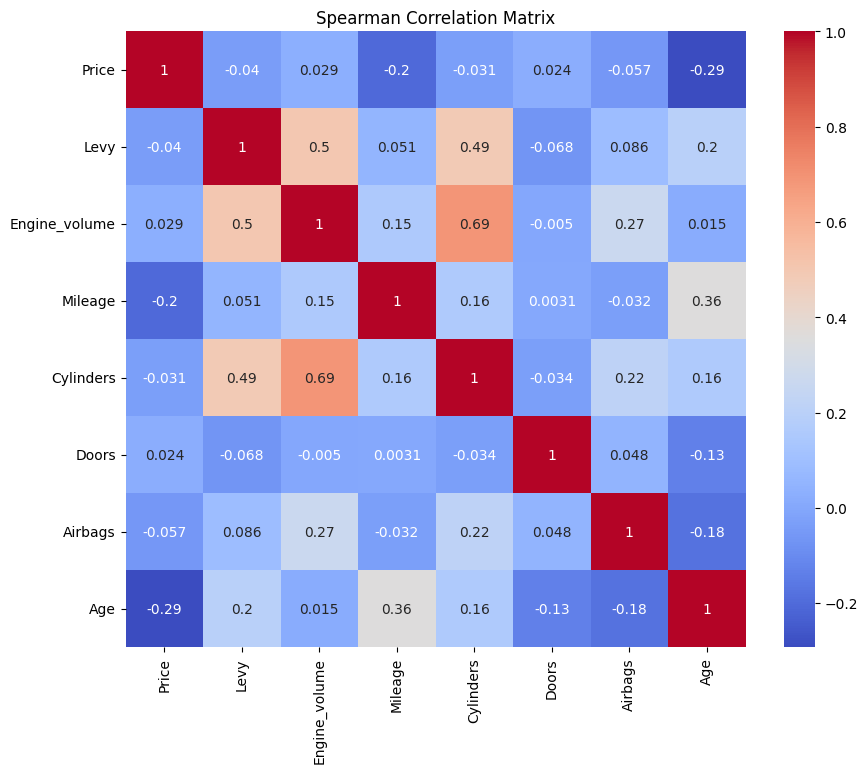

                  Price      Levy  Engine_volume   Mileage  Cylinders  \
Price          1.000000  0.005373       0.002824 -0.001758   0.007518   
Levy           0.005373  1.000000       0.553816  0.008335   0.460055   
Engine_volume  0.002824  0.553816       1.000000 -0.007432   0.798073   
Mileage       -0.001758  0.008335      -0.007432  1.000000  -0.001768   
Cylinders      0.007518  0.460055       0.798073 -0.001768   1.000000   
Doors         -0.030869 -0.037556      -0.022675 -0.006337  -0.028235   
Airbags       -0.012824  0.070009       0.232824 -0.009201   0.176868   
Age           -0.012982  0.106947       0.024350  0.063501   0.096797   

                  Doors   Airbags       Age  
Price         -0.030869 -0.012824 -0.012982  
Levy          -0.037556  0.070009  0.106947  
Engine_volume -0.022675  0.232824  0.024350  
Mileage       -0.006337 -0.009201  0.063501  
Cylinders     -0.028235  0.176868  0.096797  
Doors          1.000000  0.046003 -0.176701  
Airbags        0.046

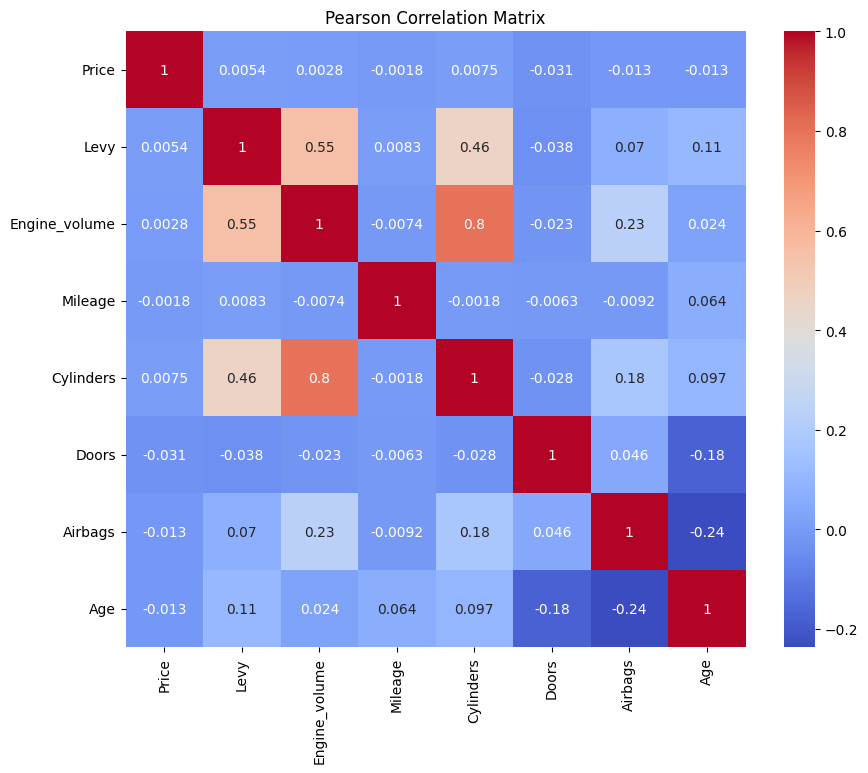

In [100]:
numerical_columns = processed_data.select_dtypes(include=['float64', 'int64'])
numerical_columns.head()

# Compute the SPEARMAN correlation matrix
corr_matrix_spearman = numerical_columns.corr(method='spearman')
print(corr_matrix_spearman)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

# Compute the PEARSON correlation matrix
corr_matrix_pearson = numerical_columns.corr(method='pearson')
print(corr_matrix_pearson)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Matrix")
plt.show()

Spearman Correlation Matrix: (Focus on monotonic relationships - can be nonlinear)
- Price has a weak negative correlation with mileage (-0.20) and age (-0.29)
- Price has ittle to no correlation with any of the other predictors
- Cylinders and engine volume have a moderately strong, positive correlation of 0.69
- Engine volume and levy have a moderatem positive correlation of 0.5 
- Cylinder and levy have a moderate positive correlation of 0.49

Pearson Correlation Matrix: (Measures linear relationships)
- Cylinders and engine volume have a strong, positive correlation of 0.8
- Levy and cylinders and levy and engine volume have similar moderate, positive correations of 0.46 and 0.55 respectivly  


In [ ]:
# OLS for predicting price

formula = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags + C(Manufacturer) + C(Model) + C(Category) + C(Leather_interior) + C(Fuel_type) + C(Gear_box_type) + C(Drive_wheels) + C(Wheel) + C(Color)'

OLS_model = smf.ols(formula=formula, data=processed_data).fit()
print(OLS_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.7128
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               1.00
Time:                        23:26:14   Log-Likelihood:            -2.3535e+05
No. Observations:               17306   AIC:                         4.734e+05
Df Residuals:                   15981   BIC:                         4.836e+05
Df Model:                        1324                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
# ANOVA
anova_table = sm.stats.anova_lm(OLS_model, typ=2)
print(anova_table)

c:\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 64, but rank is 63
  warnings.warn('covariance of constraints does not have full '


                           sum_sq       df          F    PR(>F)
C(Manufacturer)      9.124147e+11     64.0   0.346433  1.000000
C(Model)             3.762195e+13   1589.0   0.575340  1.000000
C(Category)          2.876102e+11     10.0   0.698894  0.726468
C(Leather_interior)  5.924828e+09      1.0   0.143974  0.704367
C(Fuel_type)         3.536121e+11      6.0   1.432131  0.197885
C(Gear_box_type)     1.800834e+11      3.0   1.458678  0.223661
C(Drive_wheels)      5.631060e+10      2.0   0.684175  0.504521
C(Wheel)             2.241185e+09      1.0   0.054461  0.815478
C(Color)             5.426443e+11     15.0   0.879085  0.587919
Levy                 5.859465e+10      1.0   1.423852  0.232788
Age                  3.883143e+10      1.0   0.943605  0.331367
Engine_volume        1.191535e+10      1.0   0.289543  0.590521
Mileage              6.234671e+08      1.0   0.015150  0.902040
Cylinders            2.788527e+08      1.0   0.006776  0.934395
Doors                6.842507e+11      1

c:\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1589, but rank is 1271
  warnings.warn('covariance of constraints does not have full '


- Having this many predictors is clearly causing issues in predictive power of model.
- Must conduct feature selection to check for multi-colienarity and use Variance Inflation Factor (VIF) to see which variables are redundant
- VIF > 5 means there is likely colinearly in in the feature with other features in model

In [ ]:
''' It seems the numerical features all have VIF values under 5. Engine volume and cylinders have the highest VIF values, however, they are not so high that it warrants feature removal'''

formula_numerical = 'Price ~ Levy + Age + Engine_volume + Mileage + Cylinders + Doors + Airbags'
y, X = dmatrices(formula_numerical, data=processed_data, return_type='dataframe')
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

         Feature         VIF
0      Intercept  142.222926
3  Engine_volume    3.168038
5      Cylinders    2.844389
1           Levy    1.469046
2            Age    1.126136
7        Airbags    1.115534
6          Doors    1.036400
4        Mileage    1.005112


In [ ]:
processed_data.head()

,ID,Price,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Age
0,45654403,13328,1399.000000,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,15
1,44731507,16621,1018.000000,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,14
2,45774419,8467,906.838128,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,19
3,45769185,3607,862.000000,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,14
4,45809263,11726,446.000000,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,11


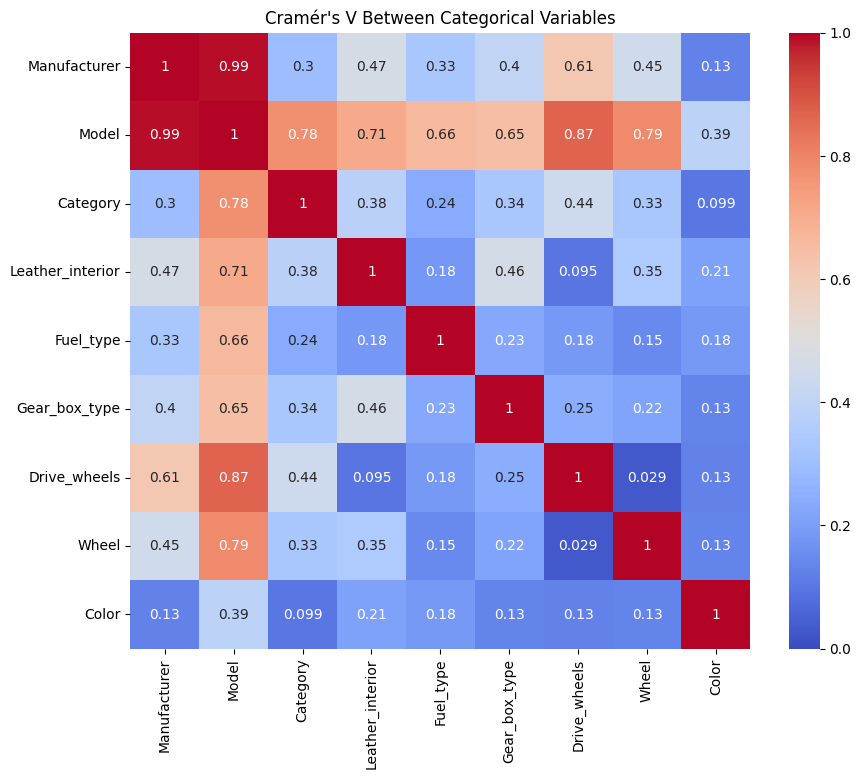

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # not enough variability
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

categorical_cols = [
    'Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
    'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color'
]

cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for feature_1 in categorical_cols:
    for feature_2 in categorical_cols:
        if feature_1 == feature_2:
            cramers_results.loc[feature_1, feature_2] = 1.0
        else:
            try:
                subset = processed_data[[feature_1, feature_2]].dropna()
                value = cramers_v(subset[feature_1], subset[feature_2])
                cramers_results.loc[feature_1, feature_2] = value
            except Exception as e:
                print(f"Error between {feature_1} and {feature_2}: {e}")
                cramers_results.loc[feature_1, feature_2] = None

cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Between Categorical Variables")
plt.show()

- Model and manufacturer have almost perfect correlation of 0.99
- Model had a very high correlation with many of the other predictors such as wheel, Drive wheels, gear box type, leather interior, category, and manufacturer
- Should remove Model feature since there is too much correlation between this and other variables

                                 PC1       PC2
Engine_volume               0.347681  0.153644
Cylinders                   0.307510  0.203750
Leather_interior_Yes        0.290898 -0.239166
Drive_wheels_4x4            0.248101  0.172772
Category_Jeep               0.215739  0.003108
Wheel_Left wheel            0.213899 -0.156121
Levy                        0.179038  0.181150
Manufacturer_MERCEDES-BENZ  0.158049  0.145258
Manufacturer_LEXUS          0.154385  0.036452
Gear_box_type_Automatic     0.119473 -0.283209
Color_Black                 0.117608  0.037968
Airbags                     0.109043 -0.009641
Fuel_type_Diesel            0.104859 -0.107634
Manufacturer_BMW            0.096625  0.124364
Drive_wheels_Rear           0.087212  0.223074
Manufacturer_AUDI           0.045633  0.017840
ID                          0.038379 -0.073005
Manufacturer_PORSCHE        0.036523  0.025017
Manufacturer_JEEP           0.028925  0.008634
Gear_box_type_Tiptronic     0.028906  0.148311


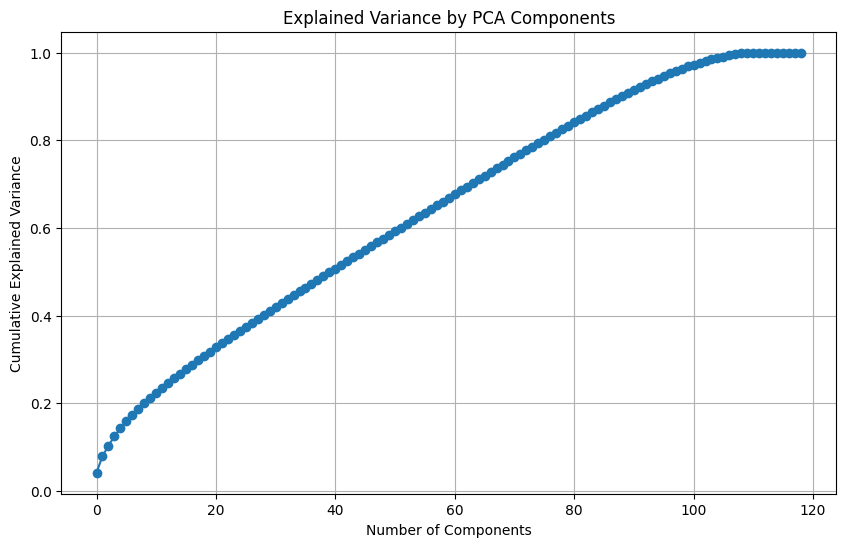

In [ ]:
# Standardize features
X = OHE_processed_data.dropna()

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_


# Create a loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(X.columns))],
    index=X.columns
)

# View top contributors to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(20))


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()